# Bike sharing regression
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle as pk
from time import time

In [2]:
df = pd.read_csv('london_bs.csv')

In [3]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [6]:
#### Feature engineering
df_cleaned = df

# merge non working days
df_cleaned['not_work_day'] = df_cleaned['is_holiday'] + df_cleaned['is_weekend']

# exploit timestamp
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'], format ="%Y-%m-%d %H:%M:%S")
df_cleaned['year'] = df_cleaned['timestamp'].dt.year
df_cleaned['month'] = df_cleaned['timestamp'].dt.month
df_cleaned['day'] = df_cleaned['timestamp'].dt.dayofweek
df_cleaned['hour'] = df_cleaned['timestamp'].dt.hour

# Add a feature which determines if it is night
#df_cleaned['is_night'] = 0
#df_cleaned.loc[(df_cleaned['hour'] < 8) | (df_cleaned['hour'] > 20), 'is_night'] = 1

# Drop useless columns
df_cleaned = df_cleaned.drop(['is_holiday','is_weekend', 'timestamp'],axis=1)

# keep only first 2/3 of the data set and last 1/3 for testing
df_train = df_cleaned[0:2*len(df_cleaned)//3]
df_test = df_cleaned[2*len(df_cleaned)//3:]

In [7]:
df_cleaned.corr()

,cnt,t1,t2,hum,wind_speed,weather_code,season,not_work_day,year,month,day,hour
cnt,1.000000,0.388798,0.369035,-0.462901,0.116295,-0.166633,-0.116180,-0.110895,0.010046,0.063757,-0.068688,0.324423
t1,0.388798,1.000000,0.988344,-0.447781,0.145471,-0.097114,-0.285851,-0.018669,-0.037959,0.332712,-0.002317,0.168708
t2,0.369035,0.988344,1.000000,-0.403495,0.088409,-0.098385,-0.285900,-0.021075,-0.044972,0.368366,-0.006824,0.153956
hum,-0.462901,-0.447781,-0.403495,1.000000,-0.287789,0.334750,0.290381,0.037705,0.072443,0.113149,0.011556,-0.295653
wind_speed,0.116295,0.145471,0.088409,-0.287789,1.000000,0.124803,0.010305,0.010405,-0.094739,-0.086383,0.001708,0.141792
weather_code,-0.166633,-0.097114,-0.098385,0.334750,0.124803,1.000000,0.098976,0.045577,-0.009234,-0.033253,0.020619,-0.041786
season,-0.116180,-0.285851,-0.285900,0.290381,0.010305,0.098976,1.000000,-0.009295,0.024400,0.203249,0.002356,0.000006
not_work_day,-0.110895,-0.018669,-0.021075,0.037705,0.010405,0.045577,-0.009295,1.000000,0.014005,-0.008954,0.729072,0.001673
year,0.010046,-0.037959,-0.044972,0.072443,-0.094739,-0.009234,0.024400,0.014005,1.000000,-0.026547,-0.002876,0.000542
month,0.063757,0.332712,0.368366,0.113149,-0.086383,-0.033253,0.203249,-0.008954,-0.026547,1.000000,-0.001080,-0.000312


Text(0.5, 1, 'Correlation matrix')

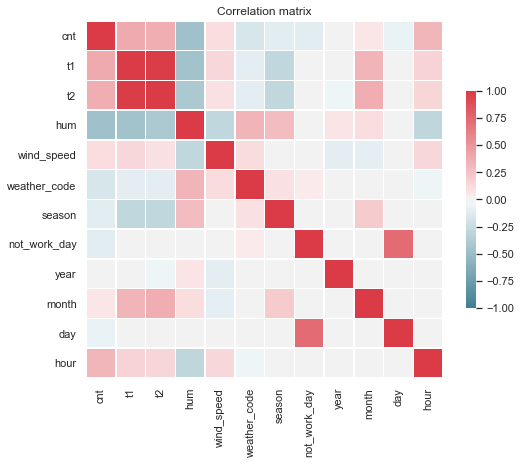

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    df_cleaned.corr(), 
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0, 
    center=0, 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.title('Correlation matrix')

In [9]:
df_train

,cnt,t1,t2,hum,wind_speed,weather_code,season,not_work_day,year,month,day,hour
0,182,3.0,2.0,93.0,6.0,3.0,3.0,1.0,2015,1,6,0
1,138,3.0,2.5,93.0,5.0,1.0,3.0,1.0,2015,1,6,1
2,134,2.5,2.5,96.5,0.0,1.0,3.0,1.0,2015,1,6,2
3,72,2.0,2.0,100.0,0.0,1.0,3.0,1.0,2015,1,6,3
4,47,2.0,0.0,93.0,6.5,1.0,3.0,1.0,2015,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...
11604,2363,14.5,14.5,46.5,8.0,1.0,0.0,0.0,2016,5,2,9
11605,1188,15.5,15.5,40.5,14.0,1.0,0.0,0.0,2016,5,2,10
11606,1208,16.0,16.0,40.5,15.0,2.0,0.0,0.0,2016,5,2,11
11607,1482,17.0,17.0,39.0,17.5,1.0,0.0,0.0,2016,5,2,12


In [10]:
df_test

,cnt,t1,t2,hum,wind_speed,weather_code,season,not_work_day,year,month,day,hour
11609,1582,18.0,18.0,37.0,16.0,1.0,0.0,0.0,2016,5,2,14
11610,1689,17.0,17.0,38.0,17.0,1.0,0.0,0.0,2016,5,2,15
11611,2292,17.5,17.5,39.5,13.0,1.0,0.0,0.0,2016,5,2,16
11612,4312,17.0,17.0,38.0,17.0,1.0,0.0,0.0,2016,5,2,17
11613,4133,16.5,16.5,26.0,17.5,1.0,0.0,0.0,2016,5,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,1.0,81.0,19.0,3.0,3.0,0.0,2017,1,1,19
17410,541,5.0,1.0,81.0,21.0,4.0,3.0,0.0,2017,1,1,20
17411,337,5.5,1.5,78.5,24.0,4.0,3.0,0.0,2017,1,1,21
17412,224,5.5,1.5,76.0,23.0,4.0,3.0,0.0,2017,1,1,22


## Machine learning

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
X = np.array(df_train[[col for col in list(df_train) if col not in ['cnt']]])

In [13]:
y = np.array(df_train[['cnt']])

In [14]:
# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Size of sets
print("Train set:",X_train.shape)
print("Train set:",y_train.shape)
print("Test set:",X_test.shape)
print("Test set:",y_test.shape)

Train set: (9287, 11)
Train set: (9287, 1)
Test set: (2322, 11)
Test set: (2322, 1)


In [15]:
# cross-validator : ShuffleSplit 
ss = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42) # To avoid over-fitting

# Functions to be used in the pipeline
skb = SelectKBest(f_regression)

### Import regressor ###
reg = RandomForestRegressor()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("SKB",skb),
    ("RDFR",reg)
])   

# parameters to tune 
param_grid = {
    "SKB__k":[5,"all"],
    "RDFR__n_estimators":[100,200],
    "RDFR__max_depth":[None],
    "RDFR__min_samples_split":[2],
    "RDFR__min_samples_leaf":[2]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = ss)

# training classifier
print (" > training classifier:")
t0 = time()
grid.fit(X_train, y_train.ravel())
print ("training time: ", round(time()-t0, 3), "s")

# best classifier using the cross-validator and the Stratified Shuffle Split 
reg = grid.best_estimator_

# predicition with the classifier
t0 = time()
pred = reg.predict(X_test)
print ("testing time: ", round(time()-t0, 3), "s")

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# dump classifier in a pickle file
print ("\n > Regressor dumped")
with open("best_reg.pkl", 'wb') as file:
    pk.dump(reg, file)

 > training classifier:
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.8min finished


training time:  170.174 s
testing time:  0.069 s

 > Best grid search:
{'RDFR__max_depth': None, 'RDFR__min_samples_leaf': 2, 'RDFR__min_samples_split': 2, 'RDFR__n_estimators': 100, 'SKB__k': 'all'}

 > Regressor dumped


In [16]:
RMSE = np.sqrt(mean_squared_error(y_test, pred))
R2 = r2_score(y_test, pred)
print('RMSE:',RMSE,'\nr2:',R2)

RMSE: 219.58242704480833 
r2: 0.9532724682346809


Text(0, 0.5, 'Importance')

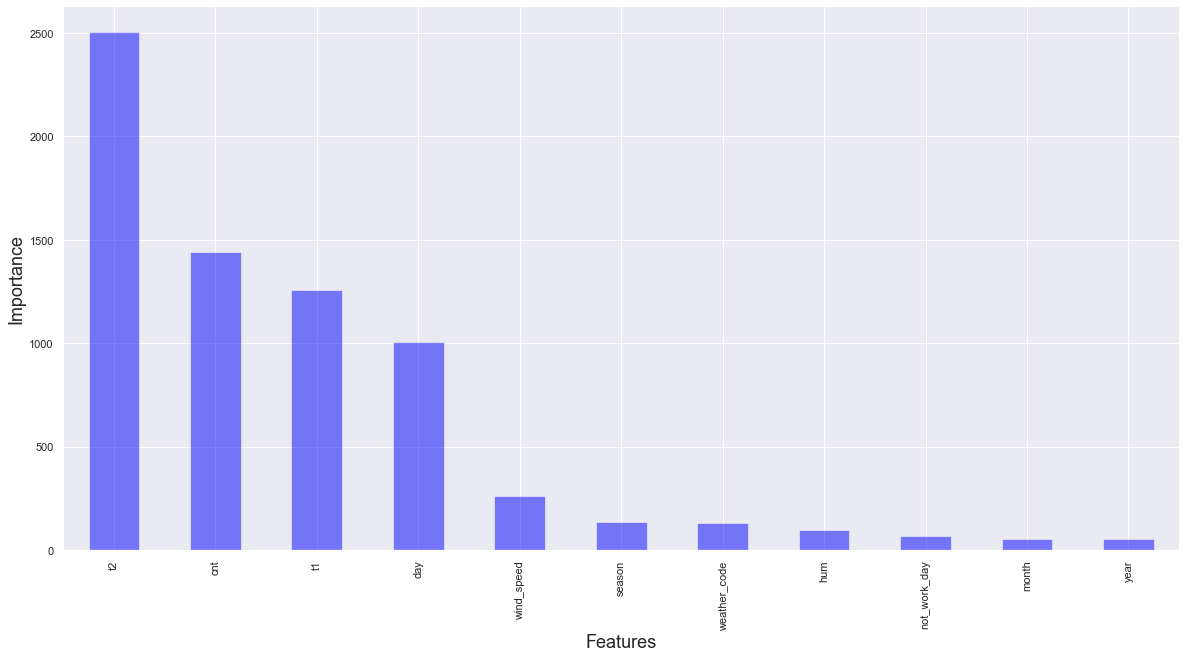

In [17]:
# List of importance for each feature
Kbest_importance =  grid.best_estimator_.named_steps['SKB'].scores_
# Dict with feature and its related importance
Kbest_dico = {list(df_cleaned)[i]: Kbest_importance[i] for i in range(len(list(df_cleaned))-1)}
# Sorting by values decreasing
plt.figure(figsize=(20,10)) 
pd.Series(Kbest_dico).head(25).sort_values(ascending = False).plot(kind='bar',color='blue',alpha=0.5);
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Importance', fontsize = 18)

## Testing regression

In [18]:
with open("best_reg.pkl", 'rb') as file:
    reg_trained = pk.load(file)

In [19]:
user_X = np.array(df_test[[col for col in list(df_test) if col not in ['cnt']]])
user_y = np.array(df_test['cnt'])
user_pred = reg_trained.predict(user_X)

In [20]:
df_res = pd.DataFrame({
    'actual':user_y,
    'prediction':user_pred
})[0:500]

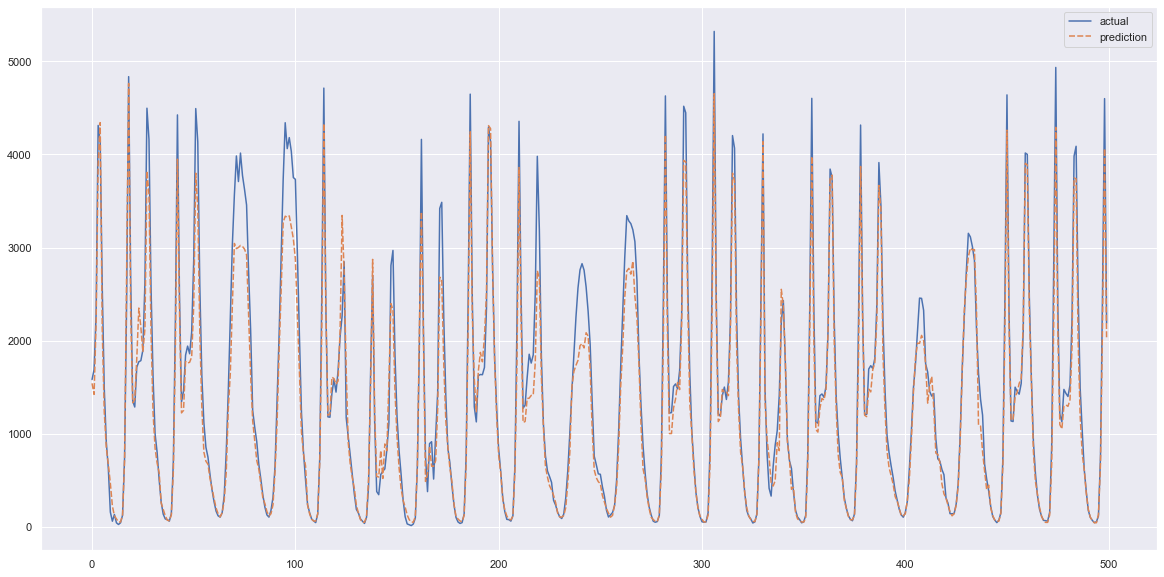

In [21]:
plt.figure(figsize=(20,10)) 
ax = sns.lineplot(data=df_res)